In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

from scipy import signal

sys.path.append('..')

from seismicpro.batchflow import Dataset
from seismicpro.src import SeismicBatch, FieldIndex, seismic_plot


In [10]:
def get_windowed_spectrogram_dists(smgr, smgl, dist_fn='sum_abs', time_frame_width=100, noverlap=None, window=('tukey', 0.25)):
    
    kwargs = dict(window=window, nperseg=time_frame_width, noverlap=noverlap)
    f, t, Sxx_l = signal.spectrogram(smgl, **kwargs)
    f, t, Sxx_r = signal.spectrogram(smgr, **kwargs)

    if callable(dist_fn):  # res(sl, sr)
        res = dist_fn(Sxx_l, Sxx_r)
    elif dist_fn == 'max_abs':
        res = np.abs(Sxx_l - Sxx_r).max(axis=1)
    elif dist_fn == 'sum_abs':
        res = np.sum(np.abs(Sxx_l - Sxx_r), axis=1)
    elif dist_fn == 'sum_sq':
        res = np.sum(np.abs(Sxx_l - Sxx_r) ** 2, axis=1)
#         elif mode == 'corr'
    else:
        raise NotImplemented('modes other than max_abs, sum_abs, sum_sq not implemented yet')

    return res
       
def draw_modifications_dist(modifications, traces_frac=0.1, distances='sum_abs', 
                            vmin=None, vmax=None, figsize=(15, 15), 
                            time_frame_width=100, noverlap=None, window=('tukey', 0.25)):
    
    fig, axs = plt.subplots(1, len(modifications), figsize=figsize)    
    origin, _ = modifications[0]
    n_traces, n_ts = origin.shape
    n_use_traces = int(n_traces*traces_frac)
    
    if isinstance(distances, str) or callable(distances):
        distances = (distances, )
    
    for i, (mod, description) in enumerate(modifications):
        distances_strings = []
        for dist_fn in distances:
            dist_m = get_windowed_spectrogram_dists(mod[0:n_use_traces], origin[0:n_use_traces], dist_fn=dist_fn, 
                                                   time_frame_width=time_frame_width, noverlap=noverlap, window=window)
#             print(dist_m.shape)
            dist = np.mean(dist_m)
            distances_strings.append("{}: {:.4}".format(dist_fn, dist))

        axs[i].imshow(mod.T, vmin=vmin, vmax=vmax, cmap='gray')
        rect = patches.Rectangle((0, 0), n_use_traces, n_ts, edgecolor='r', facecolor='none', lw=1)
        axs[i].add_patch(rect)
        axs[i].set_title("{},\ndistances from original are:\n{}".format(description, '\n'.join(distances_strings)))
        
def get_cv(arrs, q=0.95):
    return np.abs(np.quantile(np.stack(item for item in arrs), q))


In [3]:
base_path = '/notebooks/data/metrics_study_ibm_outputs/4_Metrix_QC/'
      
paths = dict(raw = '1_NA_qc_input_DN01.sgy',
            lift = '1_NA_qc_out_DN03.sgy',
            ibm_1 = '1_NA_qc_IBM_UNSUP.sgy',
            ibm_2 = '1_NA_qc_IBM_SUP.sgy',
            gpn = '1_NA_qc_GPN_1dUnet.sgy')

In [4]:
from functools import reduce

field_index = reduce(lambda x, y: x.merge(y), (FieldIndex(name=name, path=base_path+path, extra_headers=['offset']) for name, path in paths.items()))

field_index.head()

TraceNumber offset TRACE_SEQUENCE_FILE  \
                                               raw   
FieldRecord                                          
109868             1656     35                   1   
109868             1657     35                   2   
109868             1655     79                   3   
109868             1658     79                   4   
109868             1659    127                   5   

                                                       file_id  \
                                                           raw   
FieldRecord                                                      
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   

            TRACE_SEQUENCE_FILE  \
                          ibm_1   
FieldRecord                       
109868                        1   
109868                        2   
109868                        3   
109868                        4   
109868                        5   

                                                       file_id  \
                                                         ibm_1   
FieldRecord                                                      
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   

            TRACE_SEQUENCE_FILE  \
                            gpn   
FieldRecord                       
109868                        1   
109868                        2   
109868                        3   
109868                        4   
109868                        5   

                                                       file_id  \
                                                           gpn   
FieldRecord                                                      
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   

            TRACE_SEQUENCE_FILE  \
                          ibm_2   
FieldRecord                       
109868                        1   
109868                        2   
109868                        3   
109868                        4   
109868                        5   

                                                       file_id  \
                                                         ibm_2   
FieldRecord                                                      
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...   

            TRACE_SEQUENCE_FILE  \
                           lift   
FieldRecord                       
109868                        1   
109868                        2   
109868                        3   
109868                        4   
109868                        5   

                                                       file_id  
                                                          lift  
FieldRecord                                                     
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...  
109868       /notebooks/data/metrics_study_ibm_outputs/4_Me...  
109868       /

In [6]:
batch = (Dataset(field_index, SeismicBatch).next_batch(6)
         .load(fmt='segy', components=tuple(paths.keys())))

In [8]:
raw, lift, ibm_1, ibm_2, gpn = batch.raw[0], batch.lift[0], batch.ibm_1[0], batch.ibm_2[0], batch.gpn[0]

In [11]:
cv = get_cv([raw])
raw.shape

(2736, 3000)

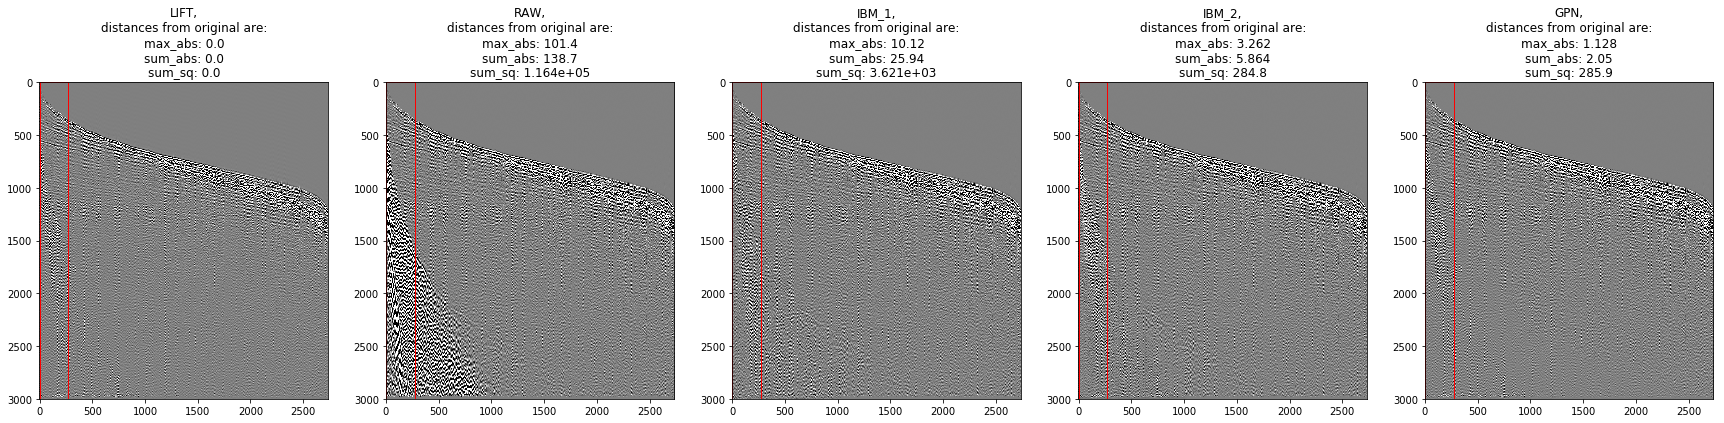

In [15]:
modifications = list(zip([lift, raw, ibm_1, ibm_2, gpn], ['LIFT', 'RAW', 'IBM_1', 'IBM_2', 'GPN']))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 10))    

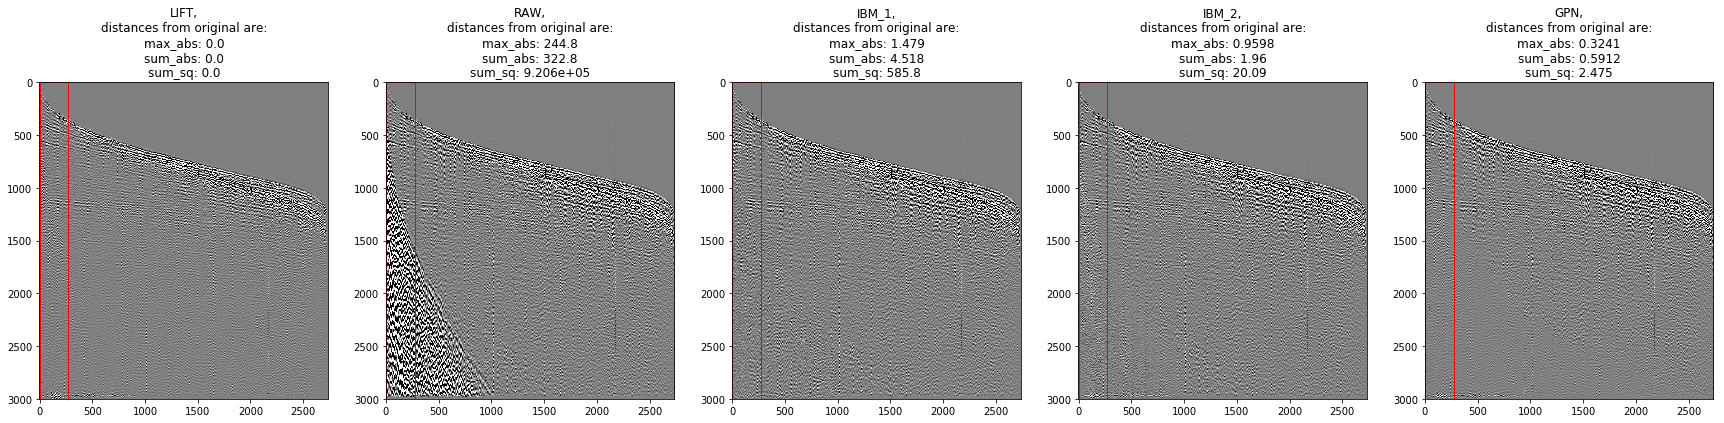

In [16]:
i=1
modifications = list(zip([batch.lift[i], batch.raw[i], batch.ibm_1[i], batch.ibm_2[i], batch.gpn[i]], ['LIFT', 'RAW', 'IBM_1', 'IBM_2', 'GPN']))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 10))    

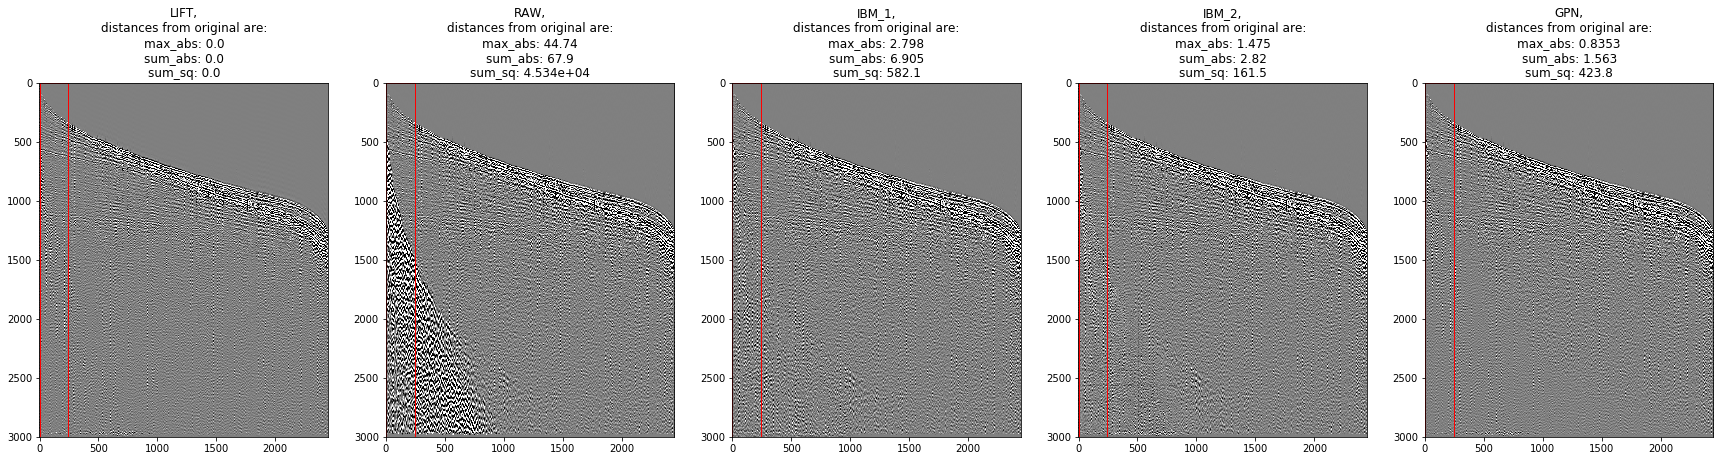

In [17]:
i=2
modifications = list(zip([batch.lift[i], batch.raw[i], batch.ibm_1[i], batch.ibm_2[i], batch.gpn[i]], ['LIFT', 'RAW', 'IBM_1', 'IBM_2', 'GPN']))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 10))    

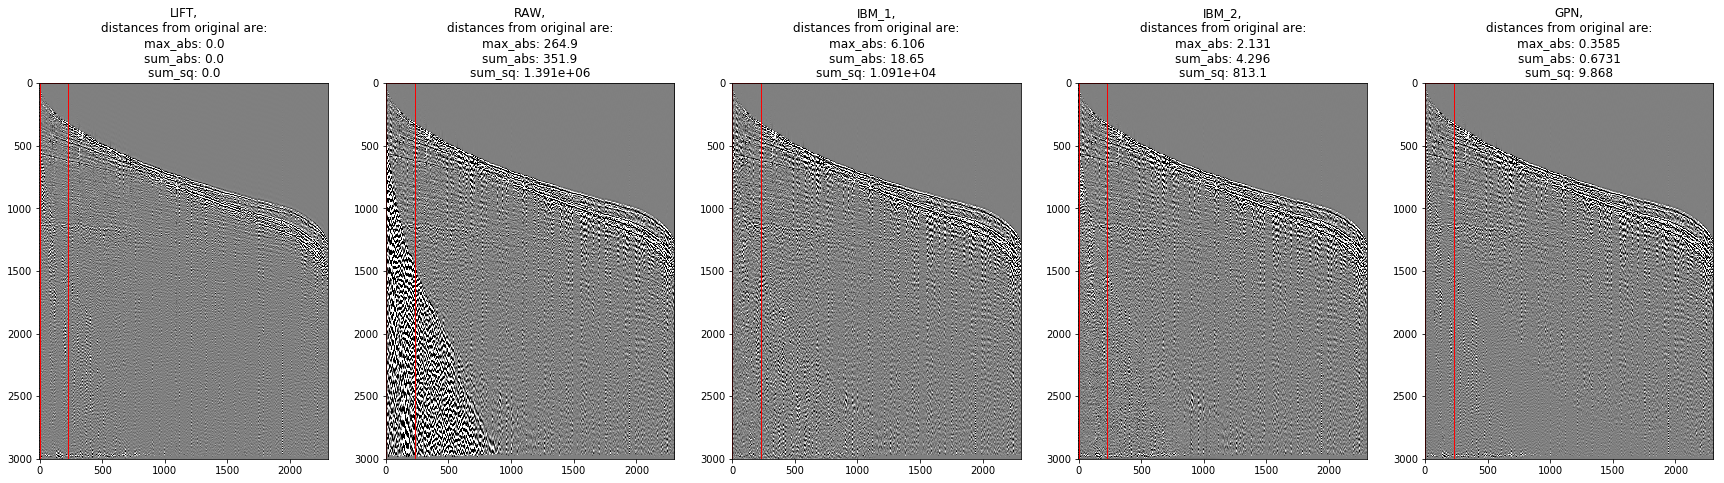

In [18]:
i=3
modifications = list(zip([batch.lift[i], batch.raw[i], batch.ibm_1[i], batch.ibm_2[i], batch.gpn[i]], ['LIFT', 'RAW', 'IBM_1', 'IBM_2', 'GPN']))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 10))    

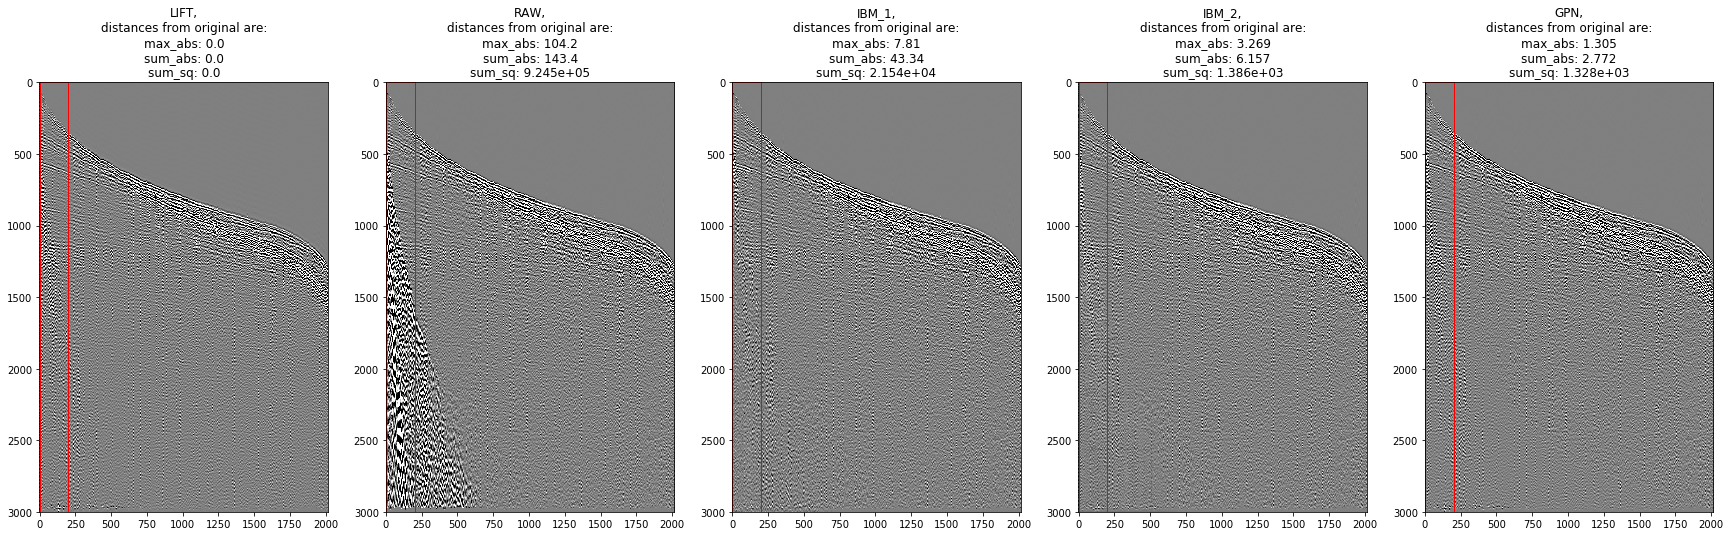

In [19]:
i=4
modifications = list(zip([batch.lift[i], batch.raw[i], batch.ibm_1[i], batch.ibm_2[i], batch.gpn[i]], ['LIFT', 'RAW', 'IBM_1', 'IBM_2', 'GPN']))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 10))    

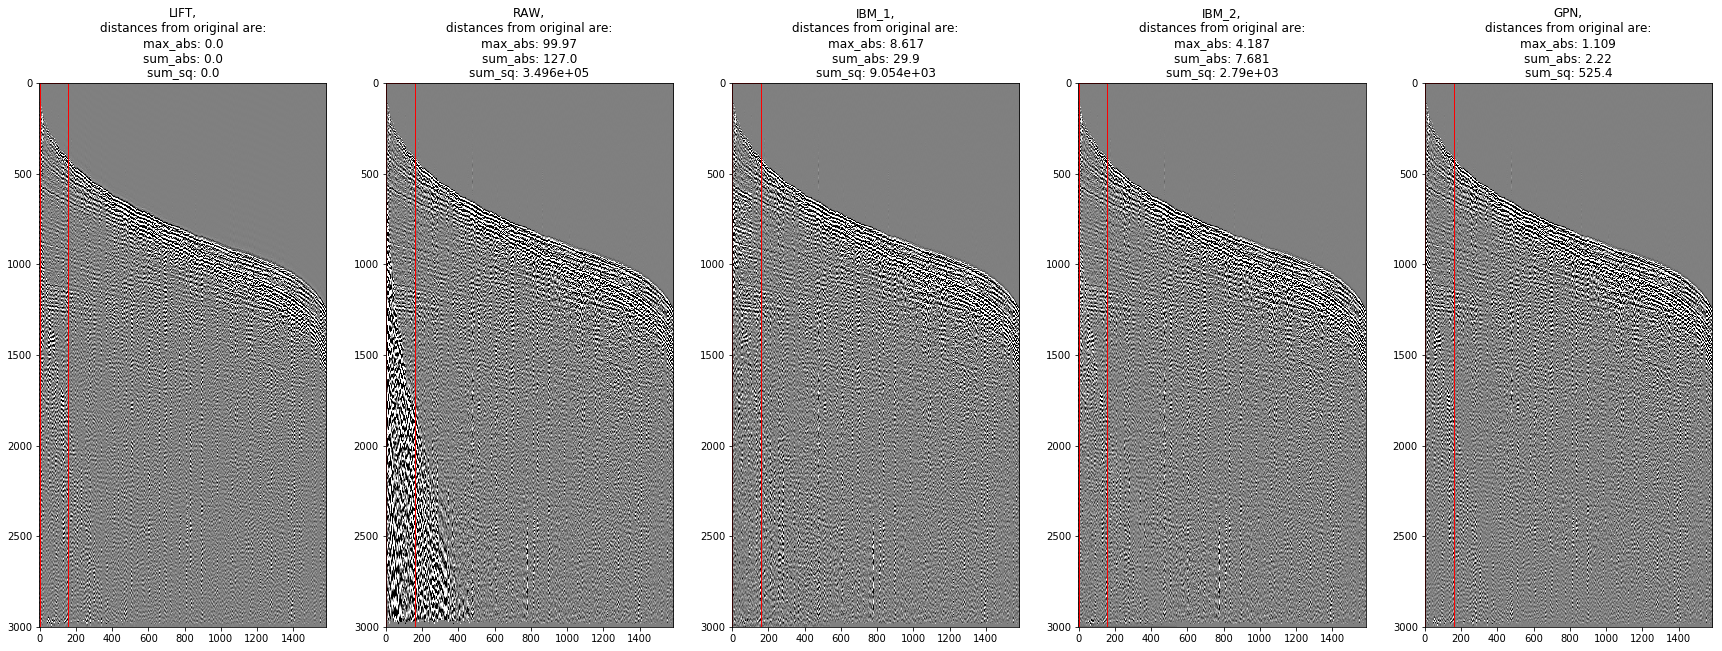

In [20]:
i=5
modifications = list(zip([batch.lift[i], batch.raw[i], batch.ibm_1[i], batch.ibm_2[i], batch.gpn[i]], ['LIFT', 'RAW', 'IBM_1', 'IBM_2', 'GPN']))

draw_modifications_dist(modifications, vmin=-cv, vmax=cv, distances=['max_abs', 'sum_abs', 'sum_sq'], figsize=(30, 10))    